In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pandas as pd

from scipy.stats import multivariate_normal, invwishart, matrix_normal

In [4]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    x_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 6*K))
    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        if show_fixed_point:
            ax[k].scatter(x_star[k][0], x_star[k][1])

        if show_states:
            c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else i for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
            '''
            # code to add the arrows in the middle of the lines (fix head_width if needed)
            for t in range(y.shape[0]-1):
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = 'navy')
            '''
            

In [5]:
# function to transform values in [0,1] in values in [-1,1]
def normalize_coordinates(y):
    y1_norm = ((y[:, 0] - 0.5)*2).reshape(-1, 1)
    y2_norm = (-(y[:, 1] - 0.5)*2).reshape(-1, 1)
    y_norm = np.concatenate([y1_norm, y2_norm], axis = 1)
    return y_norm

## Collecting data

In [6]:
dataset = pd.read_csv("Datasets/match1.csv")
dataset_1 = dataset.where(dataset.period_id == 1) # select only first half of the match
dataset_1

,Unnamed: 0,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,home_11_x,...,home_13_d,home_13_s,away_28_x,away_28_y,away_28_d,away_28_s,home_14_x,home_14_y,home_14_d,home_14_s
0,0.0,1.0,0.0,1.0,NaN,NaN,0.45472,0.61291,NaN,0.00082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.2,6.0,NaN,NaN,0.55677,0.61091,NaN,0.00140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,0.4,11.0,NaN,NaN,0.56504,0.69395,NaN,0.00085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.6,16.0,NaN,NaN,0.57330,0.77700,NaN,0.00065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,0.8,21.0,NaN,NaN,0.57247,0.79726,NaN,0.00066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
player = "home_1" # terzino sinistro
fh_x = (dataset_1[player + "_x"]).to_numpy()
fh_y = (dataset_1[player + "_y"]).to_numpy()
fh_x = fh_x[np.isnan(fh_x) == False].reshape(-1, 1)
fh_y = fh_y[np.isnan(fh_y) == False].reshape(-1, 1)
y = np.concatenate([fh_x, fh_y], axis = 1)
downsampling = 5 # how often data is taken from the trajectory (to reduce number of points)
y = y[::downsampling]
y = normalize_coordinates(y)[:500] # y is transformed to [-1,1]^2
print(y.shape)

(500, 2)


(-1.0, 1.0)

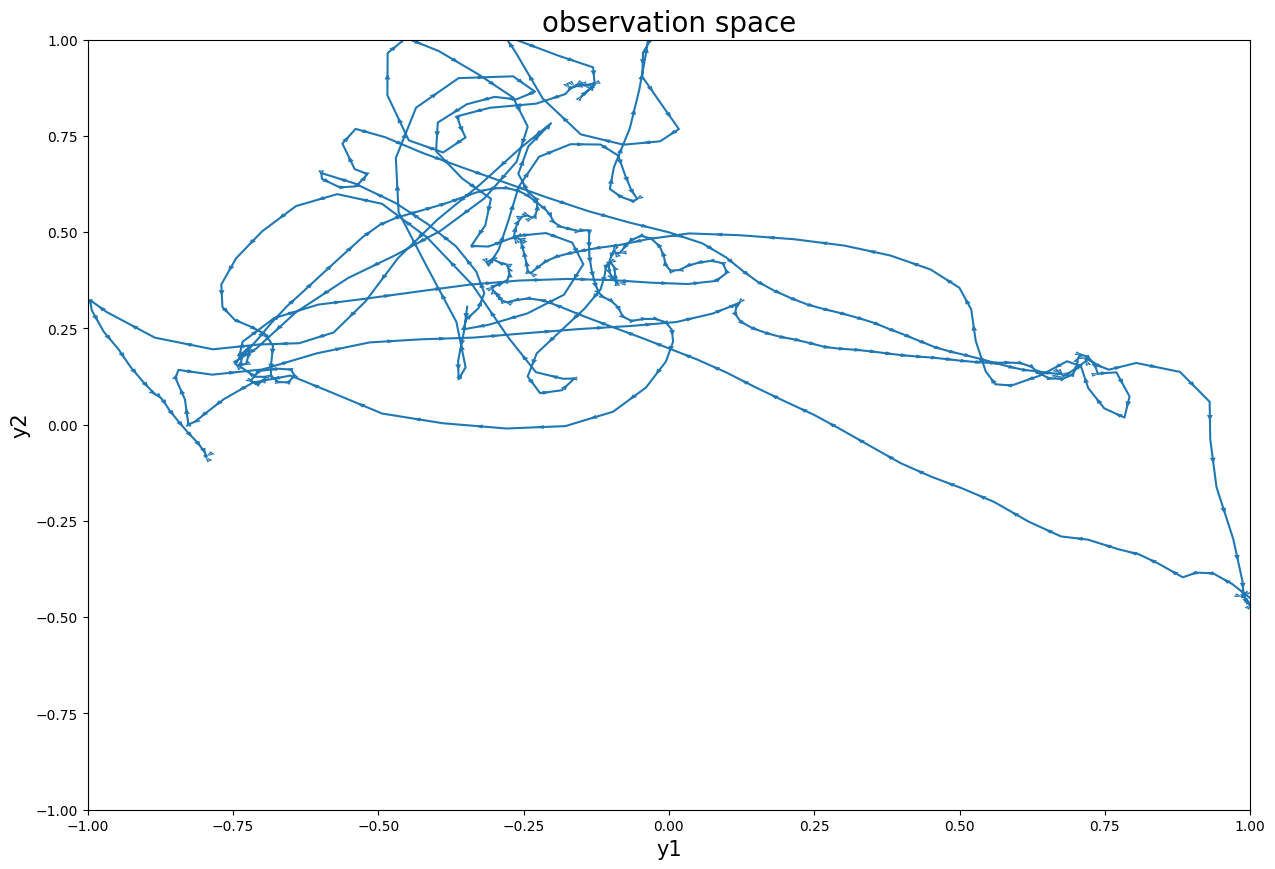

In [8]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1])

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [9]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [10]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 5 # latent dim

L = 100 # how many Gibbs iteration to do

### PRIORS
# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

#S = generate_random_semipositive_matrix(N, 1)
S = 0.0001*np.eye(N, N)
nu = N
C = 0.1*np.random.randn(N, N+1)
#V = generate_random_semipositive_matrix(N+1, 1) # it should be a semipositive matrix, given what i found
V = 0.1*np.eye(N+1, N+1)

### INFERRED VARIABLES
# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])
#M_inf[0] = np.copy(M)

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0] = 1*np.random.randn(K, N, N+1)
#A_hat_inf[0] = np.copy(A_hat) + 0.05*np.random.randn(K, N, N+1)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([0.0001*np.eye(N, N) for k in range(K)])# + np.copy(Q)# + 0.06*np.random.randn(K, N, N)

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

print(A_hat_inf[0])

[[[ 0.84612767  0.30382399  0.85447177]
  [ 0.06858696 -1.05572933 -0.15210442]]

 [[-1.99498437 -1.95408459  1.35528817]
  [ 1.5758148  -0.19778981  0.85774056]]

 [[-1.10726458 -0.94787215  0.5099169 ]
  [-0.26351818  1.21178279  0.92642114]]

 [[-1.12576712  1.1667819  -1.32328599]
  [-0.30813093  0.55174135  0.08881214]]

 [[-1.515097    0.34396902 -0.80814135]
  [ 1.8040194   0.17922443  2.29707269]]]


In [11]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

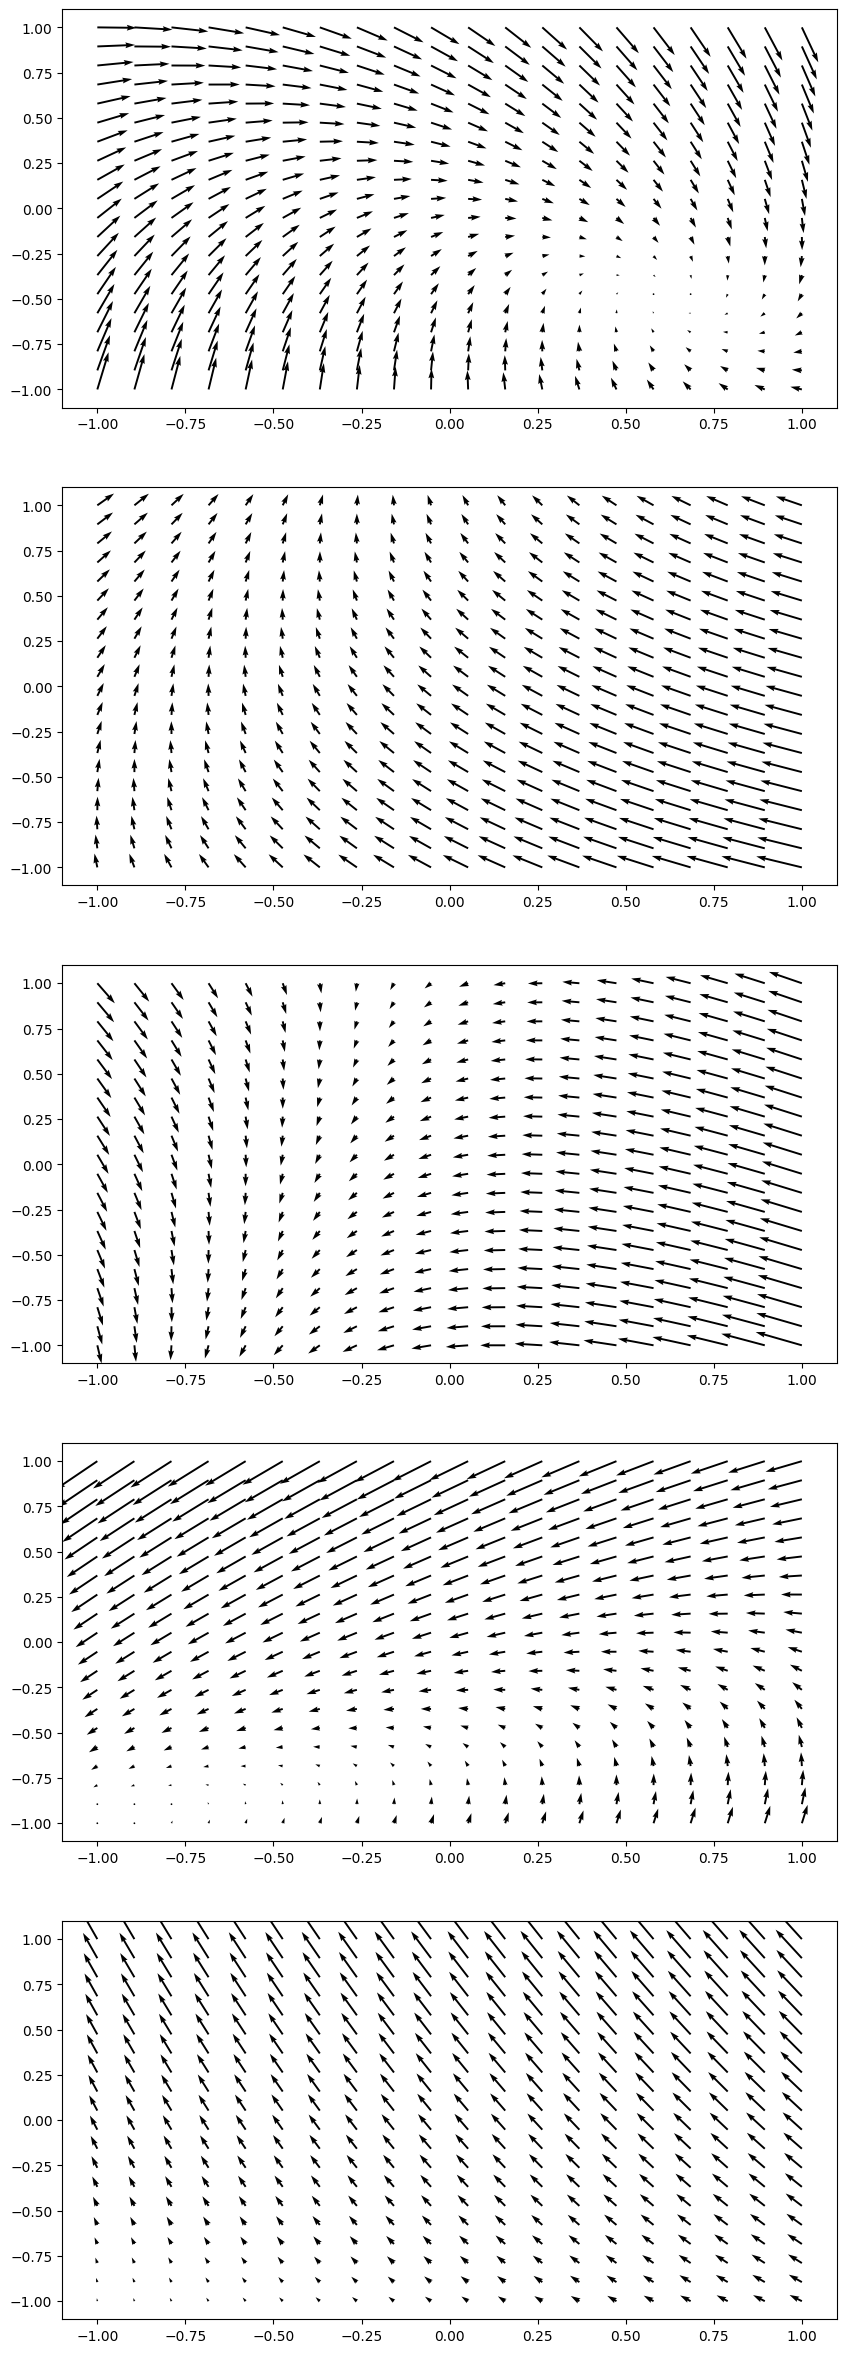

In [12]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [13]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):
    m = [np.array([1]*K)]
    log_m = [np.array([0]*K)]

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]
        
        for k in range(K):
            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # list of log messages

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [15]:
### my version of sampling z_t

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [16]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in range(L-1):
    
    #print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)

In [17]:
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[50:], return_counts=True)
print(dict(zip(unique, counts)))

[2 4 4 1 1 1 2 1 3 4 0 3 0 4 4 2 0 4 2 2 3 4 2 2 1 1 1 4 0 4 0 4 4 0 1 1 2
 3 0 4 1 4 2 2 3 1 1 2 4 2 4 1 3 3 4 0 3 2 2 0 1 2 3 0 2 0 3 2 0 2 1 4 3 0
 4 3 0 2 1 4 0 2 1 3 4 1 3 3 1 4 1 2 0 3 1 1 2 1 4 2 0 0 0 4 2 2 2 0 4 1 2
 4 0 4 4 3 1 0 4 1 2 1 0 0 1 2 4 0 0 3 3 0 1 4 4 2 4 0 0 1 3 2 2 0 4 1 2 1
 0 0 2 3 3 3 4 2 0 1 4 2 1 4 0 1 4 2 3 0 3 1 0 3 0 2 1 3 3 4 3 2 3 4 4 0 1
 3 1 2 2 3 2 3 1 0 2 2 2 3 3 2 0 3 2 1 1 2 4 1 3 3 3 1 2 1 2 3 1 3 4 4 3 4
 2 4 1 4 4 3 3 2 0 2 0 3 1 2 3 0 1 3 4 3 4 1 2 4 4 0 0 4 2 0 2 0 0 1 0 1 2
 4 0 4 3 0 4 1 3 3 0 3 2 3 0 2 3 1 3 4 4 2 2 0 3 2 2 2 4 1 2 4 2 4 1 0 0 4
 0 0 3 2 1 1 3 3 2 2 0 0 0 1 2 2 3 2 1 2 1 0 0 0 3 0 2 3 1 2 4 4 1 0 4 3 3
 2 1 1 1 3 3 0 3 4 2 1 2 1 0 1 2 4 2 0 2 0 4 0 2 3 2 4 2 4 1 4 2 3 0 2 3 3
 3 1 2 1 3 4 1 0 1 0 4 4 4 2 2 3 2 1 0 0 1 3 0 0 3 1 4 1 3 2 4 3 3 1 3 1 4
 1 2 2 2 1 0 4 0 4 2 4 1 4 2 0 1 3 4 3 4 0 0 2 2 0 0 1 0 1 3 4 3 0 3 2 0 2
 2 4 3 2 2 0 3 4 1 1 3 2 3 0 0 3 3 4 4 4 3 1 4 0 4 0 1 3 2 1 0 0 3 4 2 4 2
 2 2 4 4 4 4 2 4 2 2 0 1 

In [18]:
print(np.mean(M_inf, axis = 0))
eigw_inf, eigv_inf = np.linalg.eig(np.mean(M_inf, axis = 0).T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0]))

[[0.94034063 0.00351857 0.04528048 0.00413175 0.00672857]
 [0.18421658 0.19919155 0.22864804 0.19573857 0.19220526]
 [0.08964048 0.01407054 0.88447164 0.00629371 0.00552363]
 [0.18640781 0.18623032 0.25571377 0.17799165 0.19365645]
 [0.1865454  0.19961316 0.2356765  0.17968804 0.1984769 ]]
[0.62705211 0.01496965 0.33151689 0.01234129 0.01412006]


In [19]:
print(np.mean(A_hat_inf, axis = 0))

[[[ 0.00512512  1.00241187  0.04429567]
  [ 0.01343468 -0.03029365  0.94531574]]

 [[ 0.21994656  0.00245392  0.07948362]
  [ 0.21137782  0.29575389 -0.31140936]]

 [[-0.04558049  0.98702611  0.03178416]
  [-0.00115102  0.01272377  1.00616638]]

 [[ 0.21459531  0.01690733  0.07805313]
  [ 0.07919521 -0.01942843  0.1377426 ]]

 [[ 0.21433415  0.00549227  0.08734804]
  [ 0.09966248 -0.02663021  0.15942453]]]


In [20]:
Q_inf_av = np.mean(Q_inf, axis = 0)
for k in range(K):
    print(Q_inf_av[k])
    eigw_q, _ = np.linalg.eig(Q_inf_av[k])
    print(eigw_q)

[[ 1.08713411e-03 -7.38667256e-05]
 [-7.38667256e-05  7.03100723e-04]]
[0.00110085 0.00068938]
[[ 0.20336234  3.07600463]
 [ 3.07600463 49.10941683]]
[1.06527183e-02 4.93021265e+01]
[[2.14316333e-03 2.48630772e-05]
 [2.48630772e-05 4.02936232e-03]]
[0.00214284 0.00402969]
[[0.00843273 0.00012318]
 [0.00012318 0.00303999]]
[0.00843554 0.00303718]
[[ 0.00272093 -0.00068303]
 [-0.00068303  0.00327716]]
[0.00226157 0.00373653]


In [21]:
#b_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,0]
#A_inf_av = np.mean(A_hat_inf[L//2:], axis = 0)[:,:,1:]
b_inf_av = A_hat_inf[-1][:,:,0]
A_inf_av = A_hat_inf[-1][:,:,1:]

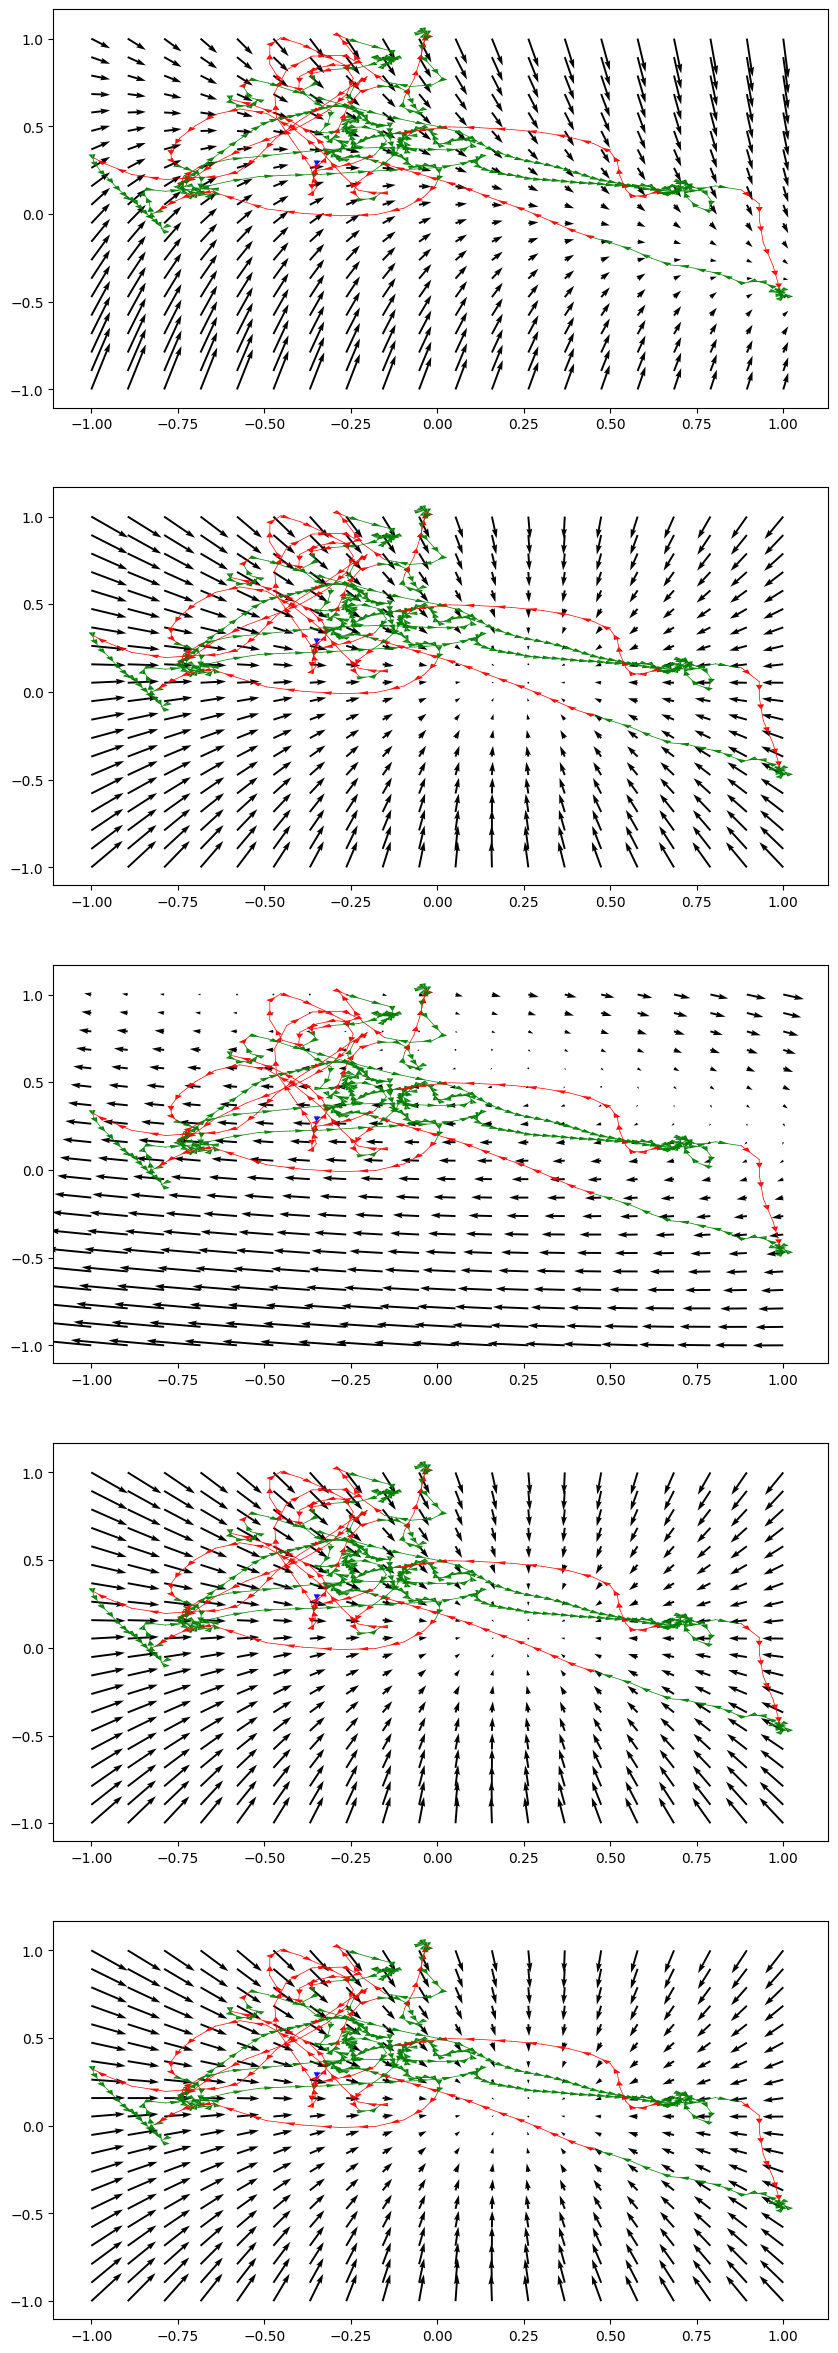

In [22]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_inf[-1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7418b957-40c0-4b8c-8b59-f82ba42a5a5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>